In [1]:
import glob
import os 

import requests 

import pandas as pd
import numpy as np

import arrow
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_32531/3213723860.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
rv_path = "/workspaces/capstone/Notebooks/Investigating local markets/datasets/computed/Realised variance"
glob.glob(f"{rv_path}/*.csv")

['/workspaces/capstone/Notebooks/Investigating local markets/datasets/computed/Realised variance/us_rvs.csv',
 '/workspaces/capstone/Notebooks/Investigating local markets/datasets/computed/Realised variance/jpn_rvs.csv',
 '/workspaces/capstone/Notebooks/Investigating local markets/datasets/computed/Realised variance/che_rvs.csv',
 '/workspaces/capstone/Notebooks/Investigating local markets/datasets/computed/Realised variance/chi_rvs.csv']

In [3]:
jpn_rvs = pd.read_csv(f"{rv_path}/jpn_rvs.csv", parse_dates=[0], index_col=0).sort_index()
us_rvs = pd.read_csv(f"{rv_path}/us_rvs.csv", parse_dates=[0], index_col=0).sort_index()
che_rvs = pd.read_csv(f"{rv_path}/che_rvs.csv", parse_dates=[0], index_col=0).sort_index()
chi_rvs = pd.read_csv(f"{rv_path}/chi_rvs.csv", parse_dates=[0], index_col=0).sort_index()

### Visualisation of RVs

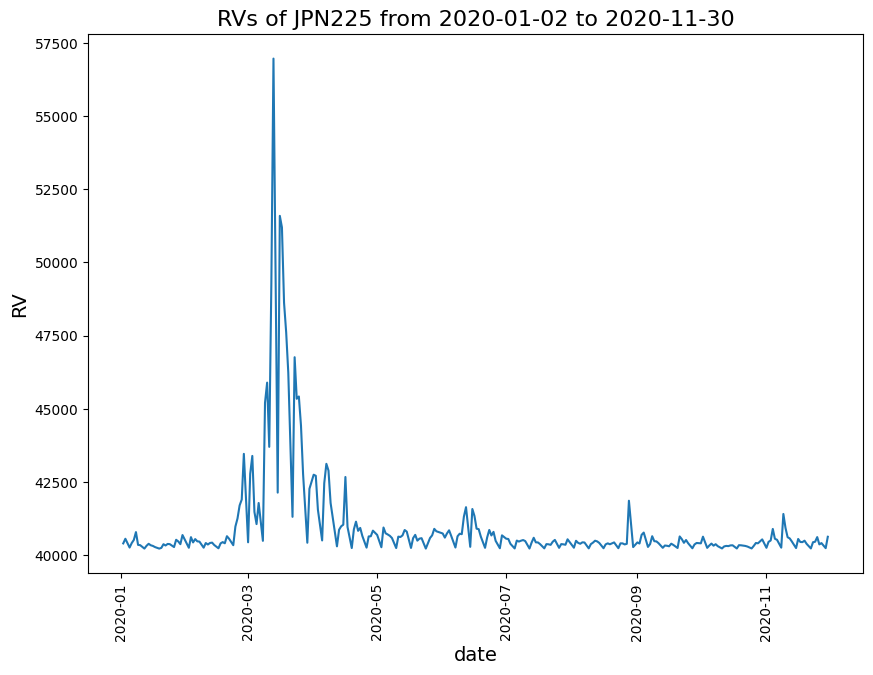

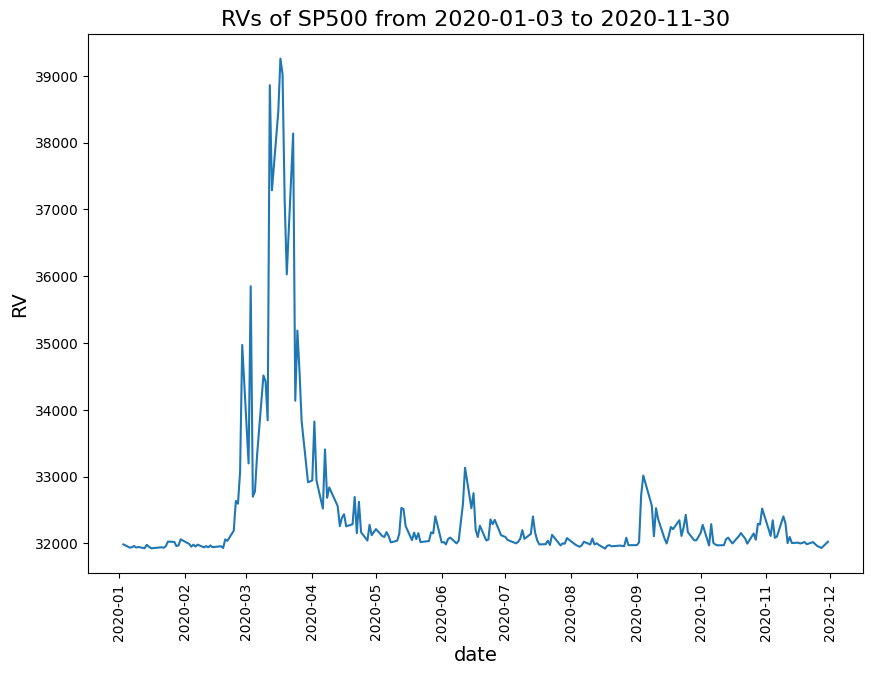

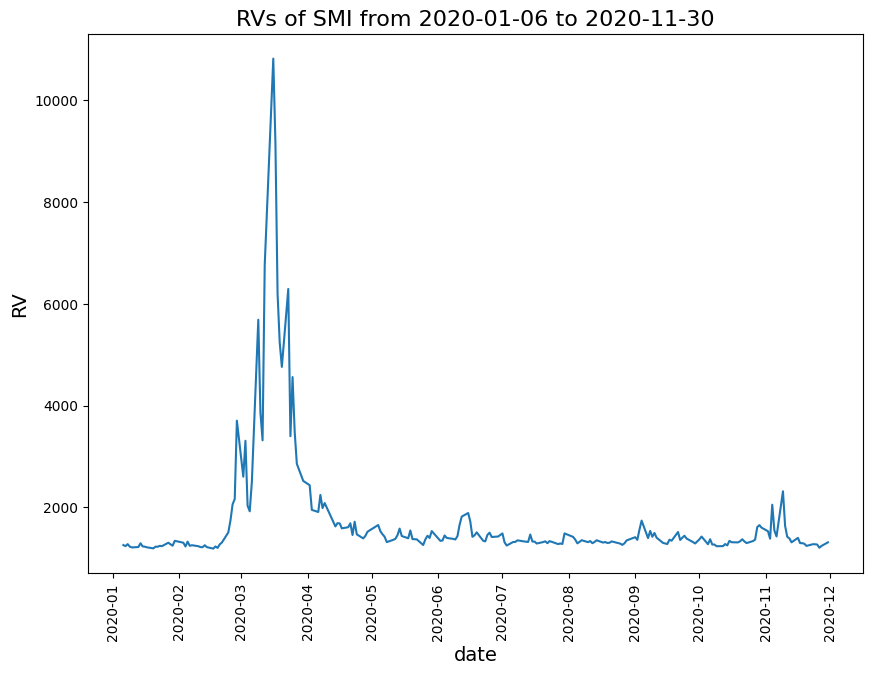

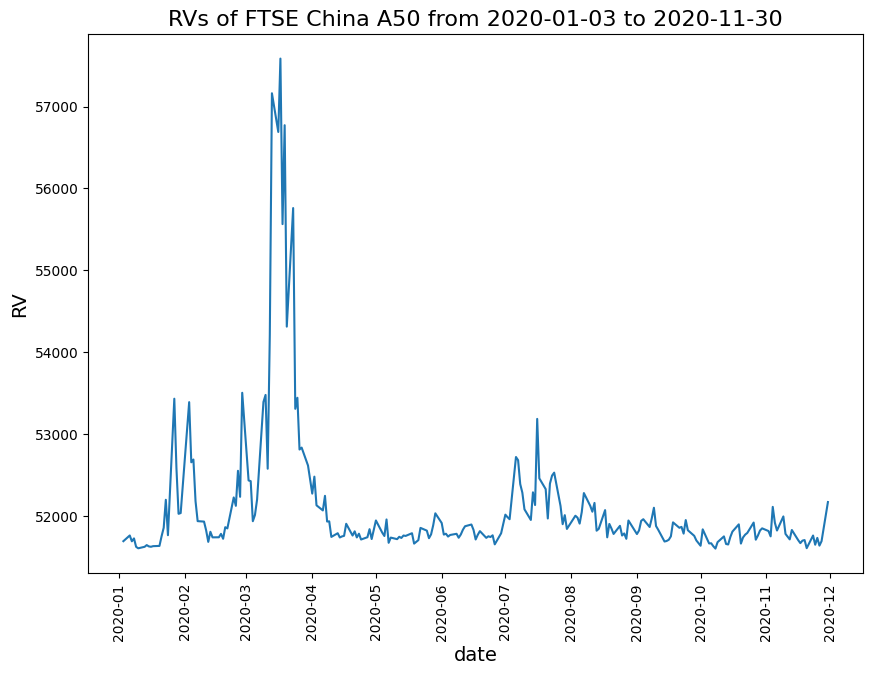

In [4]:
dfs_rvs = [jpn_rvs, us_rvs, che_rvs, chi_rvs]
indices = ["JPN225", "SP500", "SMI", "FTSE China A50"]
for i in range(len(dfs_rvs)):
    df = dfs_rvs[i]
    #keep_up_to = 150 # keep latest n dates of timeseries
    #keep_up_to = None # keep all dates
    plt.figure(figsize=(10,7))
    plt.plot(df.index, df.RV.loc[df.index])
    plt.xticks(rotation=90)
    plt.xlabel("date", size=14)
    plt.ylabel("RV", size=14)
    plt.title(f"RVs of {indices[i]} from {df.index[0].date()} to {df.index[-1].date()}", size=16)
    plt.show()

### Comparison with COVID data

In [5]:
# compare RVs with covid data
from granger_causality_functions import scale_data, plot_time_series, plot_correlation_matrix, make_stationary
from granger_causality_functions import grangers_causality_matrix, network_granger, granger_causality

In [6]:
# redownload covid and put in folder
countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-01"
end_date = "2020-12-01" 
dfs = {} # dfs of cumulative confirmed cases
covid_path = "./datasets/covid"
for country in countries_of_interest:
    if os.path.isfile(f"datasets/covid/{country}.csv"):
        df = pd.read_csv(f"datasets/covid/{country}.csv", parse_dates=[0], index_col=["date"])
    else:
        query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
        res = requests.get(query).json()
        df = pd.DataFrame(res["result"]).set_index("date")
        df.index = pd.DatetimeIndex(df.index)
        df["ts_in_secs"] = df.index.astype(int)
        df["new_confirmed"] = df["confirmed"].diff().fillna(0)
        df.to_csv(f"{covid_path}/{country}.csv")
        
    dfs[country] = df

In [7]:
dfs["USA"].head(10)

,confirmed,deaths,recovered,ts_in_secs,new_confirmed,new_confirmed_rolling
date,,,,,,
2020-01-22,1,0,0,1579651200000000000,0.0,0.000000
2020-01-23,1,0,0,1579737600000000000,0.0,0.000000
2020-01-24,2,0,0,1579824000000000000,1.0,0.000000
2020-01-25,2,0,0,1579910400000000000,0.0,0.000000
2020-01-26,5,0,0,1579996800000000000,3.0,0.000000
2020-01-27,5,0,0,1580083200000000000,0.0,0.000000
2020-01-28,5,0,0,1580169600000000000,0.0,0.571429
2020-01-29,6,0,0,1580256000000000000,1.0,0.714286
2020-01-30,6,0,0,1580342400000000000,0.0,0.714286


STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.3468
 No. Lags Chosen      = 16
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.1573. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.447
 No. Lags Chosen      = 8
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.5596. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

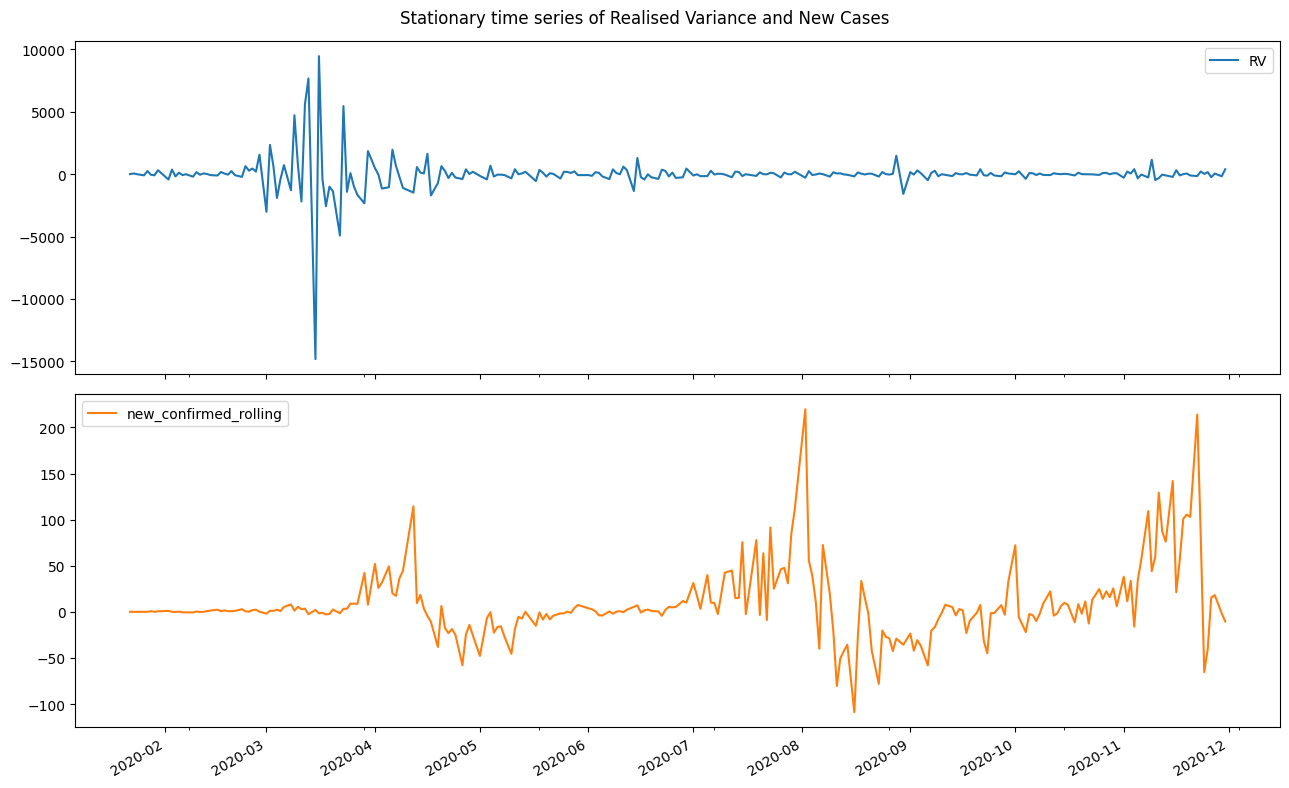


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.923
new_confirmed_rolling_y,0.901,0.0


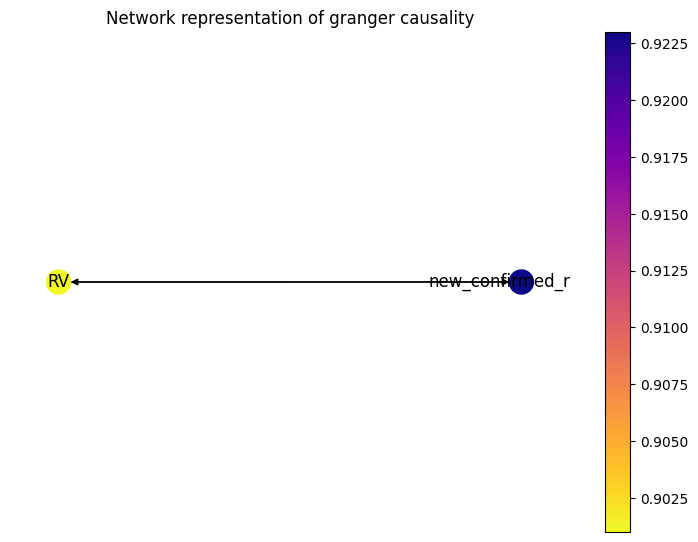

,RV_x,new_confirmed_rolling_x
RV_y,0.000,0.923
new_confirmed_rolling_y,0.901,0.000


In [8]:
# compare each country's index's RVs with their respective COVID dynamic
granger_vars = ["RV", "new_confirmed_rolling"]
jpn_merged = pd.merge(jpn_rvs[["RV"]], dfs["JPN"][["new_confirmed_rolling"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(jpn_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.7887
 No. Lags Chosen      = 10
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0599. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.1556
 No. Lags Chosen      = 13
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.6924. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

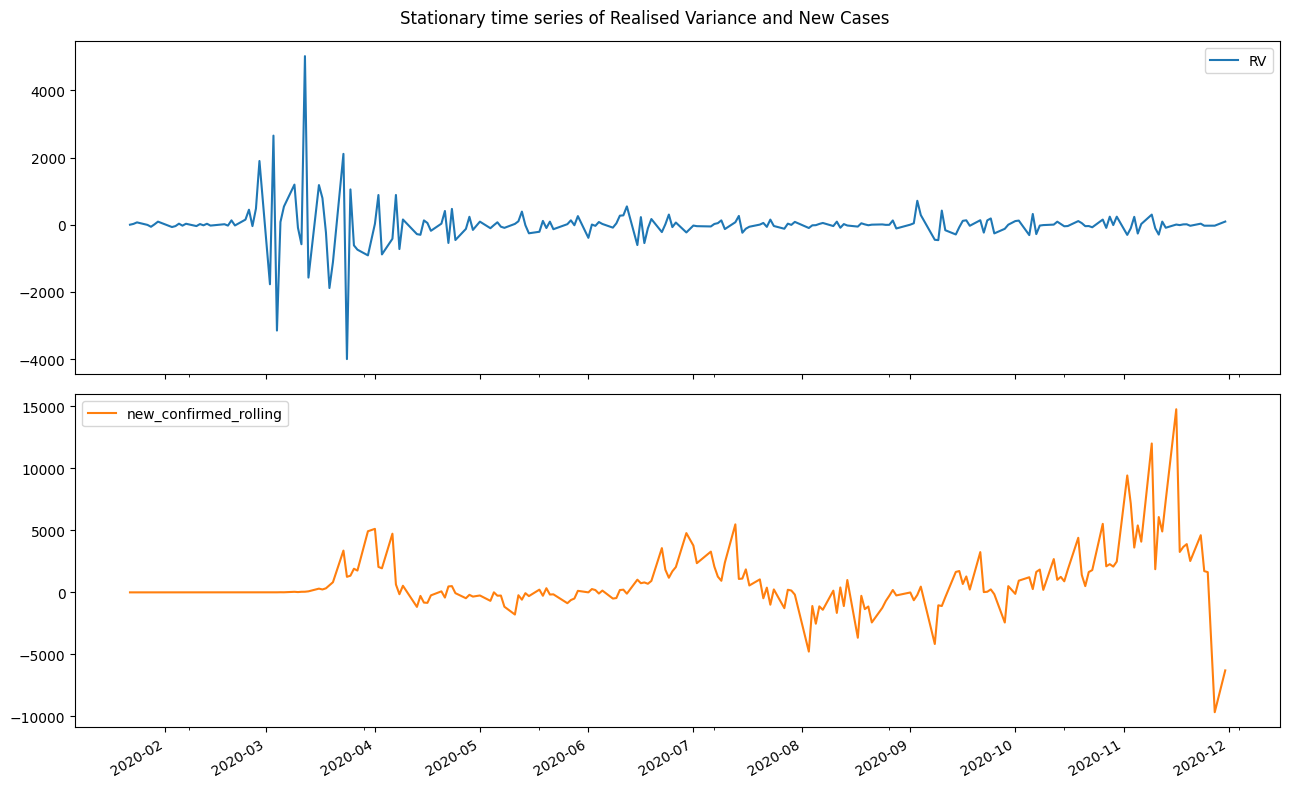


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.537
new_confirmed_rolling_y,0.373,0.0


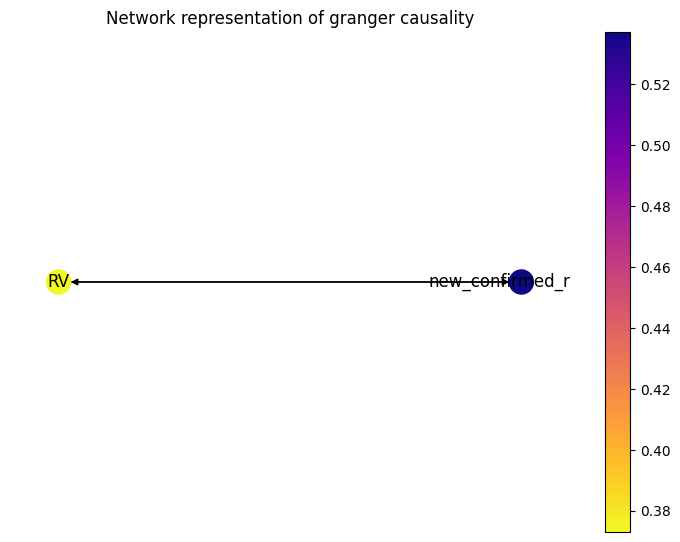

,RV_x,new_confirmed_rolling_x
RV_y,0.000,0.537
new_confirmed_rolling_y,0.373,0.000


In [9]:
us_merged = pd.merge(us_rvs[["RV"]], dfs["USA"][["new_confirmed_rolling"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(us_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.8564
 No. Lags Chosen      = 12
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0507. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.2575
 No. Lags Chosen      = 12
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.6484. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

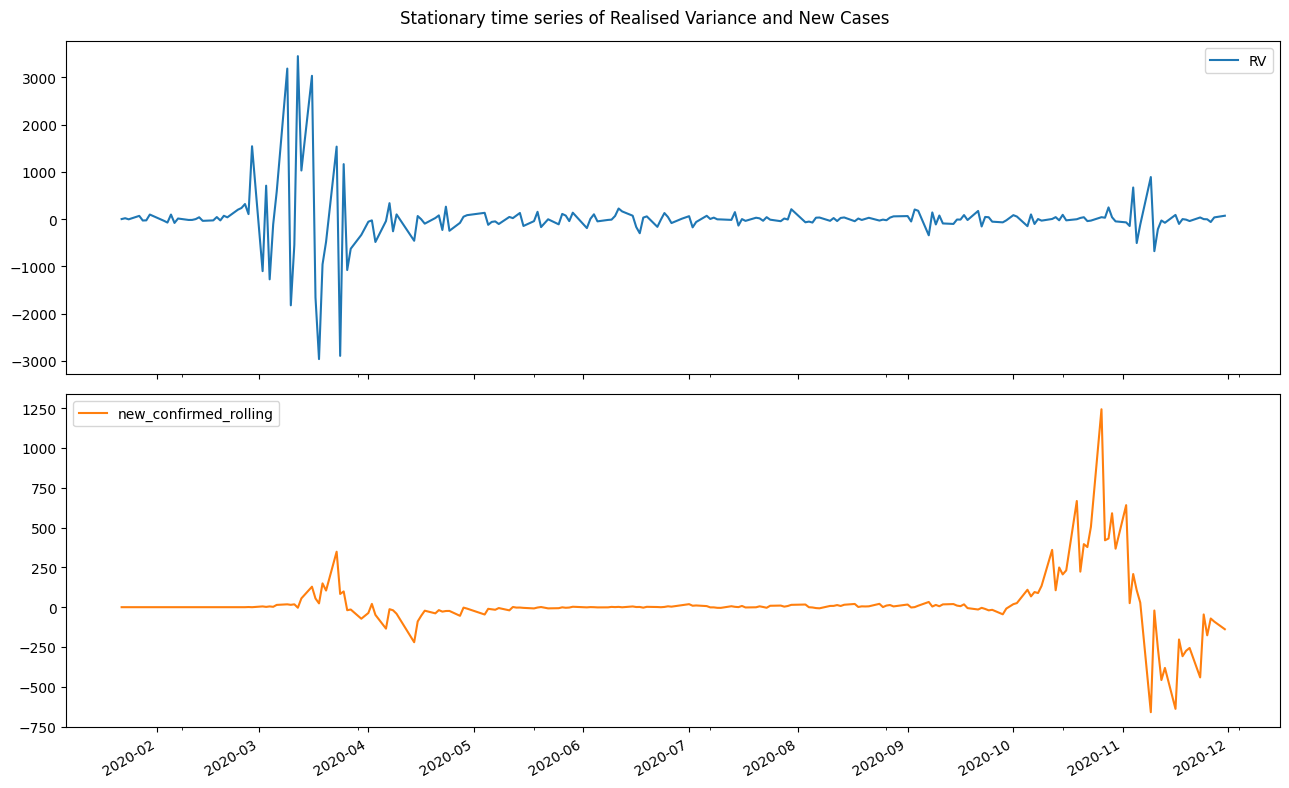


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.661
new_confirmed_rolling_y,0.0,0.0


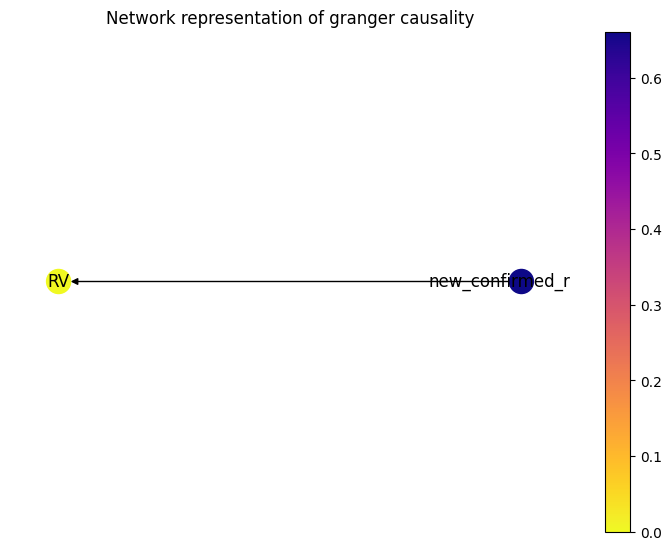

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.661
new_confirmed_rolling_y,0.0,0.000


In [10]:
che_merged = pd.merge(che_rvs[["RV"]], dfs["CHE"][["new_confirmed_rolling"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(che_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.0663
 No. Lags Chosen      = 12
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0292. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -9.8617
 No. Lags Chosen      = 15
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting H0.
 => Series is Stationary




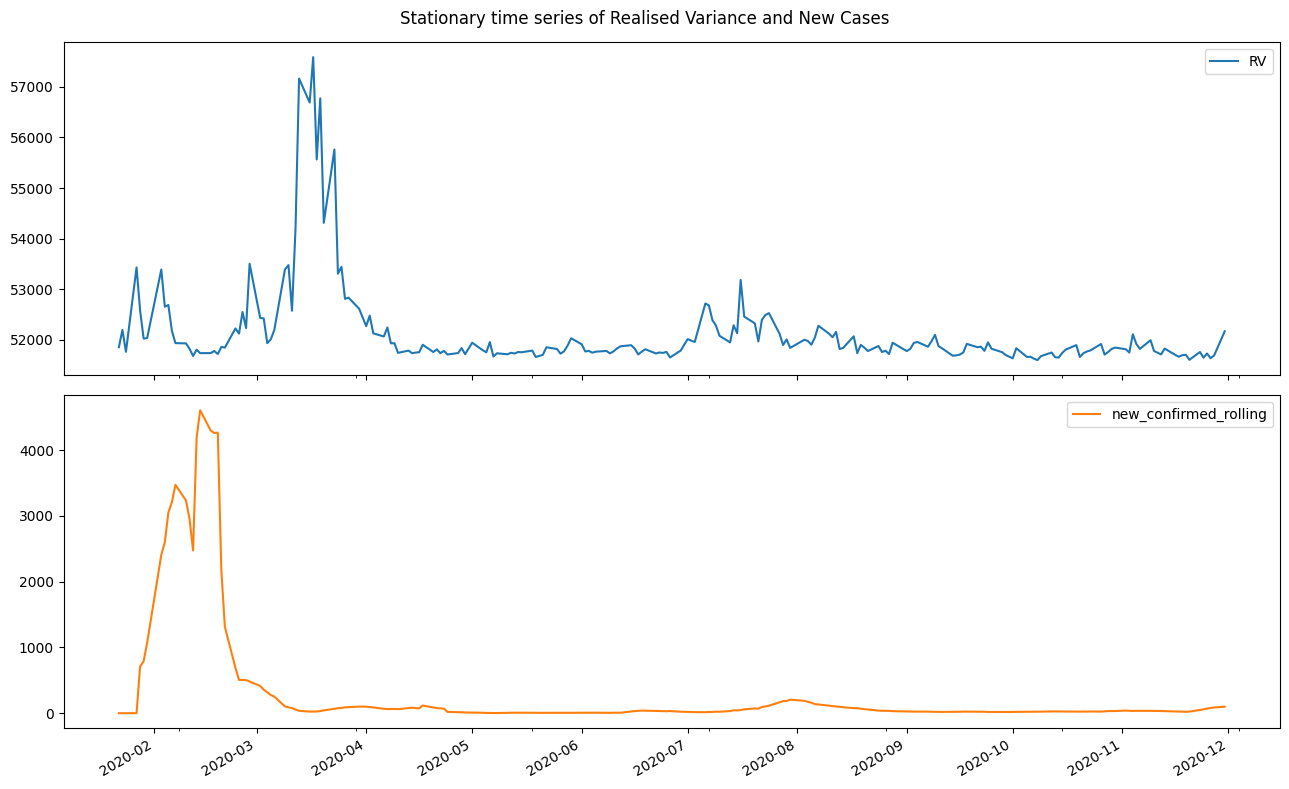


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


In [11]:
chi_merged = pd.merge(chi_rvs[["RV"]], dfs["CHN"][["new_confirmed_rolling"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(chi_merged, granger_vars, "Realised Variance and New Cases")

### Divide in periods of lockdown

In [12]:
# Japan: 7th April - 25th May
# China: 23rd Jan - 10th March
# Switzerland:  17th March - 27th April
period_jpn = ("2020-04-04", "2020-05-25")
period_chi = ("2020-01-23", "2020-04-01") #extended so that GC works
period_che = ("2020-03-17", "2020-05-17") #extended
period_us = ("2020-03-20", "2020-05-15") #extended 

In [13]:
lockdown_jpn_rvs = jpn_rvs[period_jpn[0]:period_jpn[1]]
lockdown_us_rvs = us_rvs[period_us[0]:period_us[1]]
lockdown_che_rvs = che_rvs[period_che[0]:period_che[1]]
lockdown_chi_rvs = chi_rvs[period_chi[0]:period_chi[1]]

In [14]:
lockdown_jpn_rvs.head()

,j,R,RV
2020-04-05,-12.633936,1.128779,40507.769812
2020-04-06,-12.633936,8.884891,42462.310088
2020-04-07,-12.633936,11.513150,43124.631274
2020-04-08,-12.633936,10.598481,42894.134599
2020-04-09,-12.633936,6.206509,41787.357875


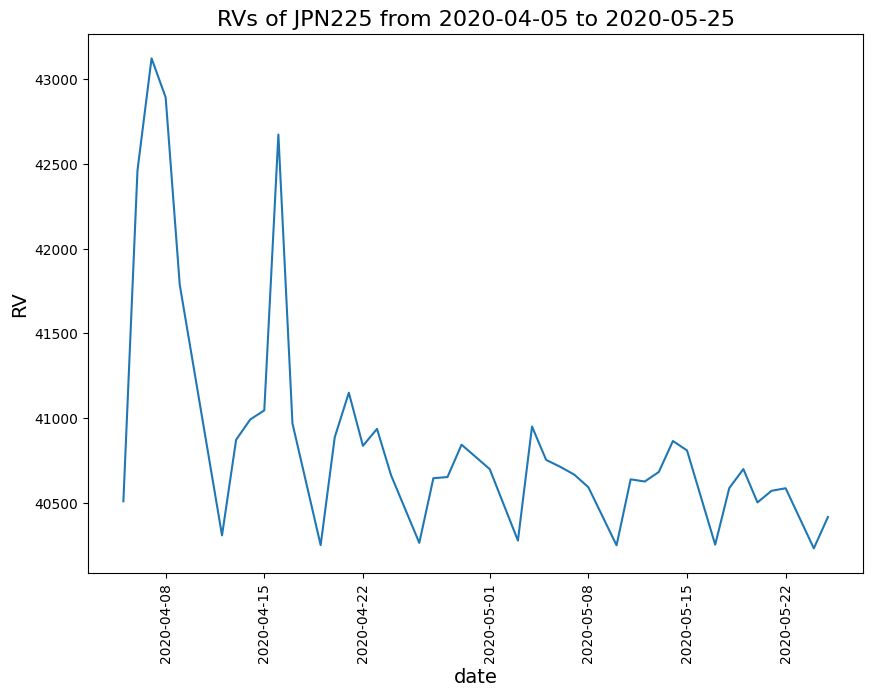

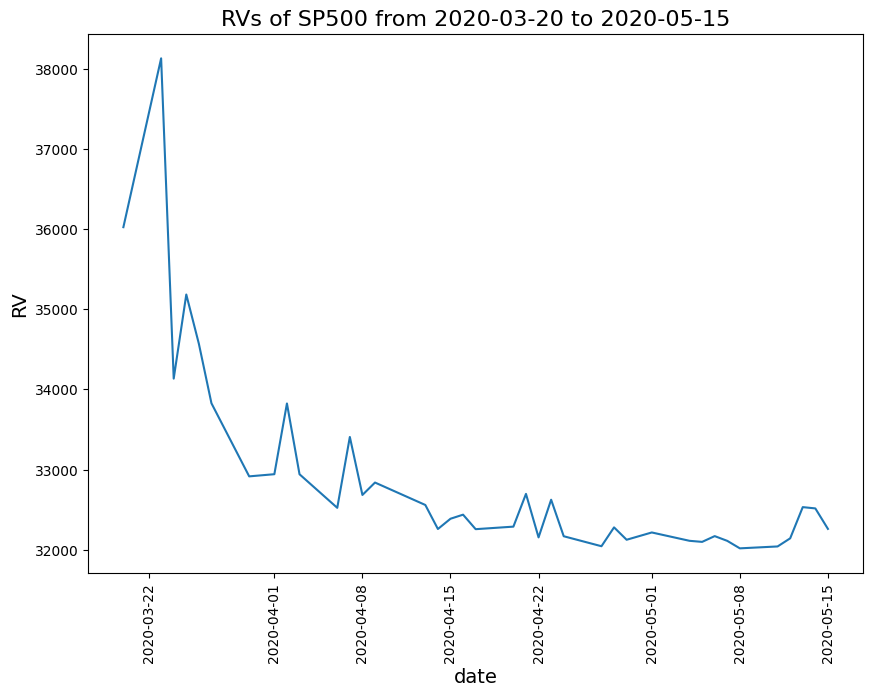

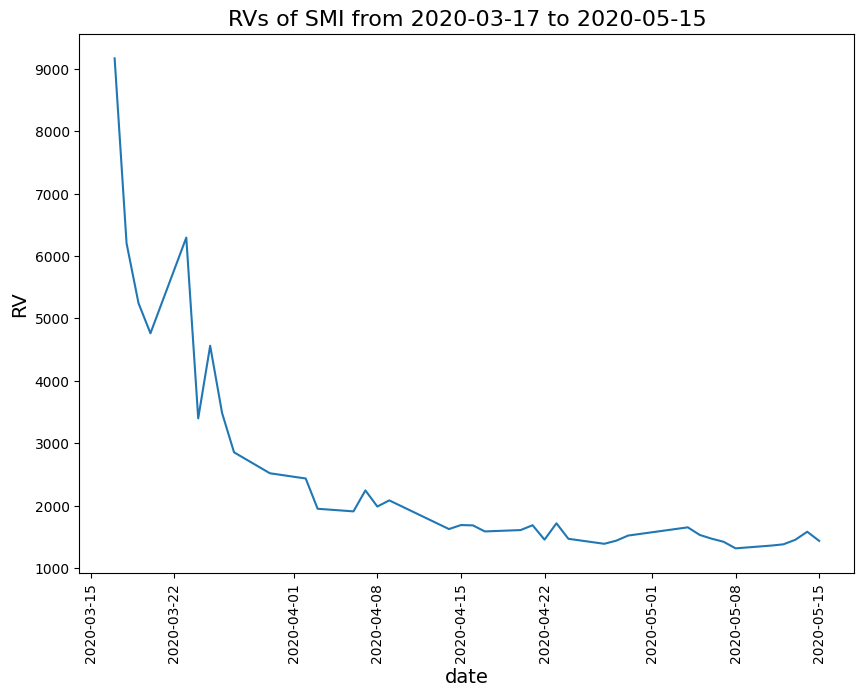

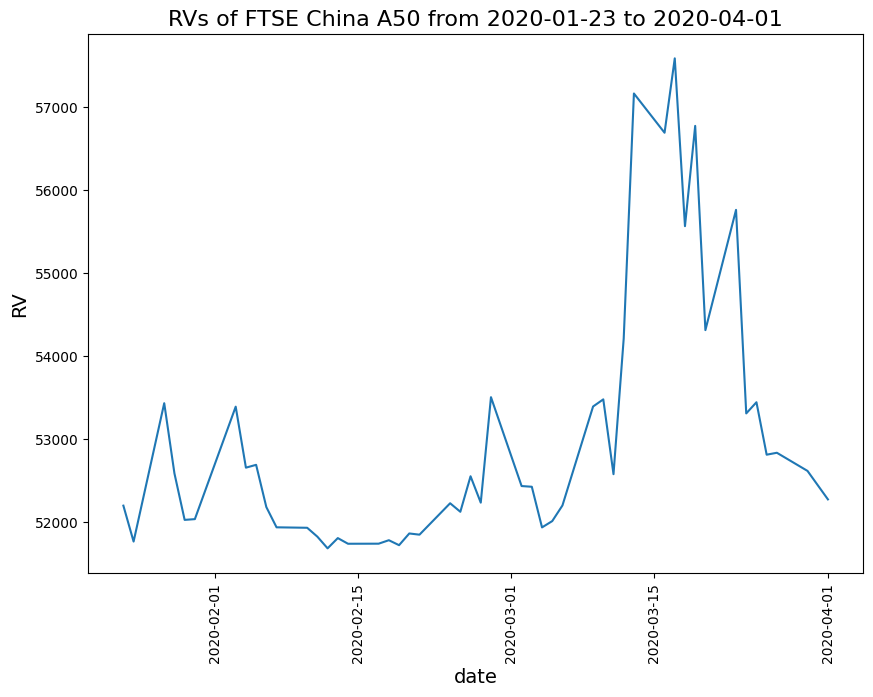

In [15]:
dfs_lockdown_rvs = [lockdown_jpn_rvs, lockdown_us_rvs, lockdown_che_rvs, lockdown_chi_rvs]
indices = ["JPN225", "SP500", "SMI", "FTSE China A50"]
for i in range(len(dfs_rvs)):
    df = dfs_lockdown_rvs[i]
    #keep_up_to = 150 # keep latest n dates of timeseries
    plt.figure(figsize=(10,7))
    plt.plot(df.index, df.RV.loc[df.index])
    plt.xticks(rotation=90)
    plt.xlabel("date", size=14)
    plt.ylabel("RV", size=14)
    plt.title(f"RVs of {indices[i]} from {df.index[0].date()} to {df.index[-1].date()}", size=16)
    plt.show()

In [16]:
dfs_covid_lockdown = {}
periods = {"JPN": period_jpn, "USA": period_us, "CHE": period_che, "CHN": period_chi}

for country in countries_of_interest:
    df = dfs[country]
    dfs_covid_lockdown[country] = df[periods[country][0]: periods[country][1]]

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.5127
 No. Lags Chosen      = 10
 Critical value 1%     = -3.661
 Critical value 5%     = -2.961
 Critical value 10%    = -2.619
 => P-Value = 0.0077. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.2097
 No. Lags Chosen      = 7
 Critical value 1%     = -3.639
 Critical value 5%     = -2.951
 Critical value 10%    = -2.614
 => P-Value = 0.0194. Rejecting H0.
 => Series is Stationary




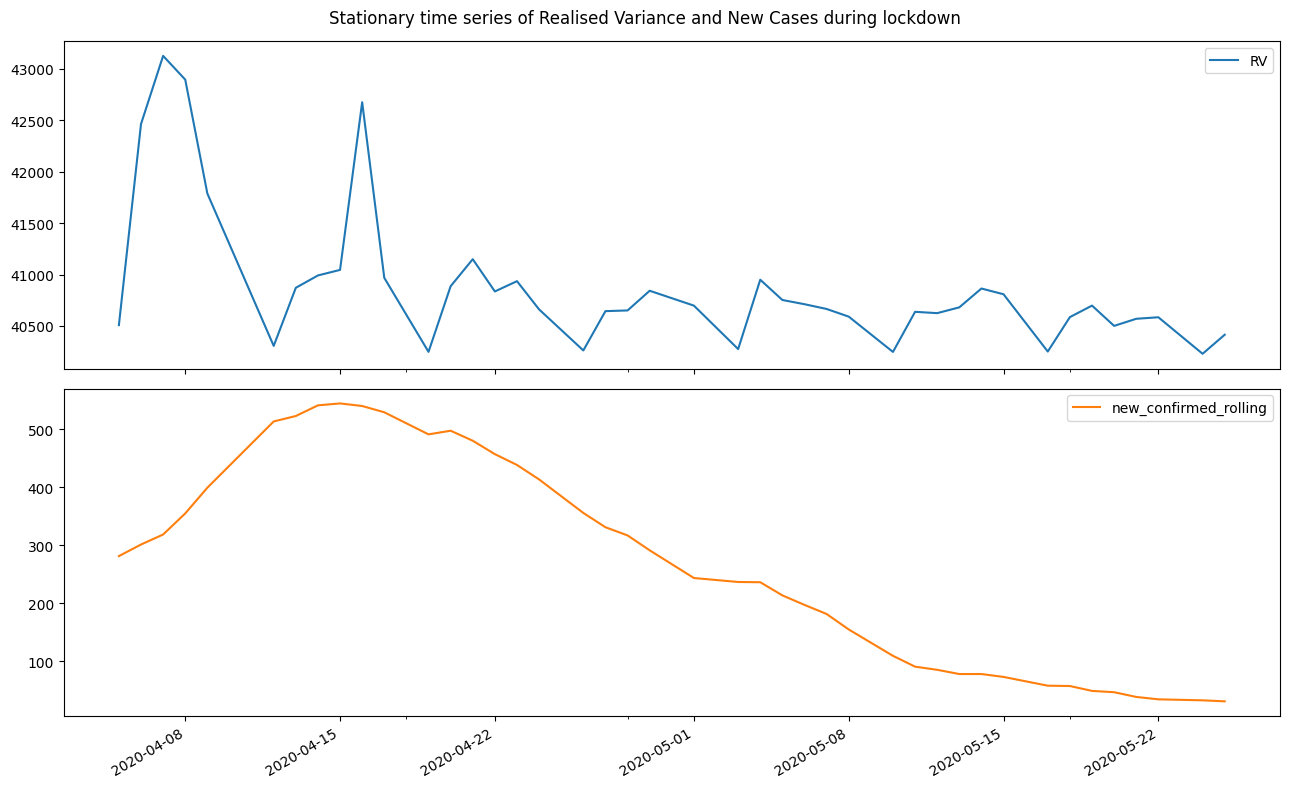


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


In [17]:
# compare each country's index's RVs with their respective COVID dynamic
granger_vars = ["RV", "new_confirmed_rolling"]
lockdown_jpn_merged = pd.merge(lockdown_jpn_rvs[["RV"]], dfs_covid_lockdown["JPN"][["new_confirmed_rolling"]], 
                      how="inner", left_index=True,
                      right_index=True)
granger_causality(lockdown_jpn_merged, granger_vars, "Realised Variance and New Cases during lockdown")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.7774
 No. Lags Chosen      = 8
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0616. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.3186
 No. Lags Chosen      = 1
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.166. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

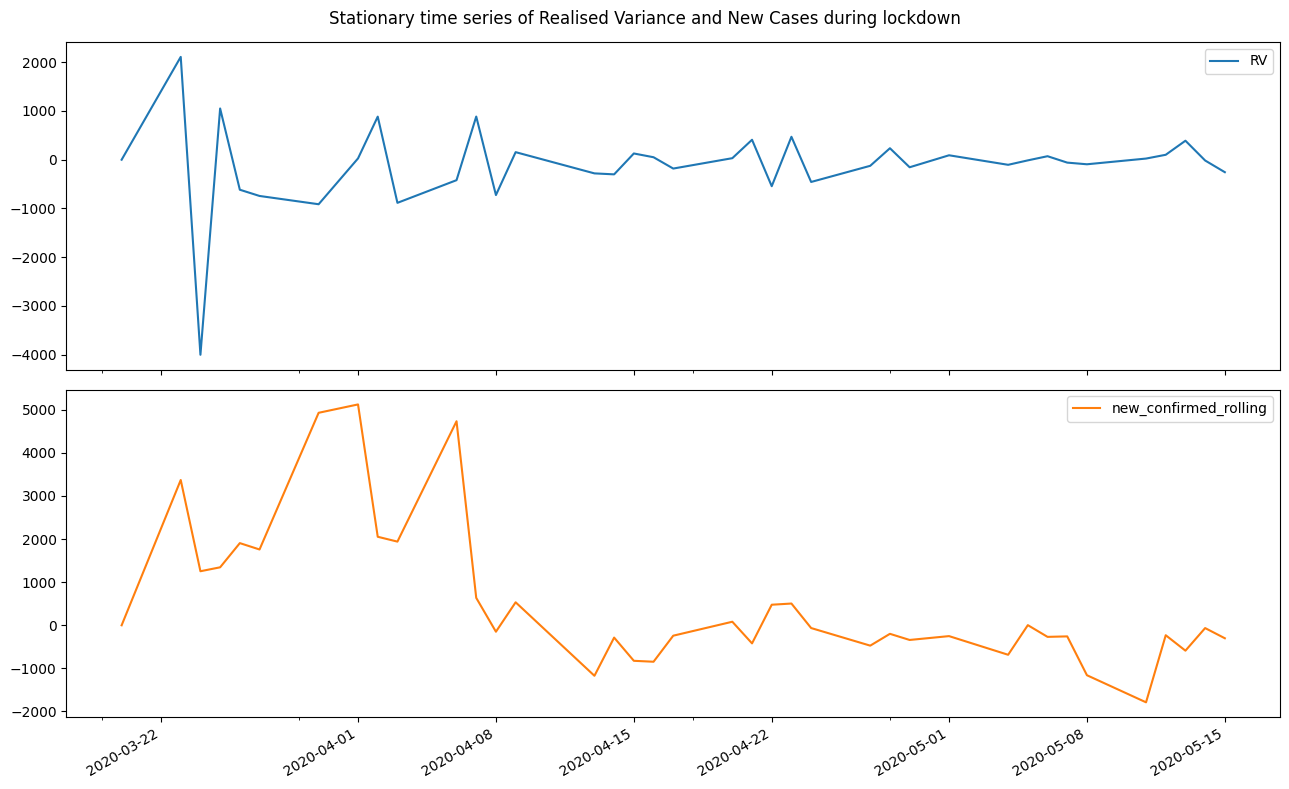


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


In [18]:
lockdown_us_merged = pd.merge(lockdown_us_rvs[["RV"]], dfs_covid_lockdown["USA"][["new_confirmed_rolling"]], 
                      how="inner", left_index=True,
                      right_index=True)
granger_causality(lockdown_us_merged, granger_vars, "Realised Variance and New Cases during lockdown")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.0867
 No. Lags Chosen      = 9
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -0.2701
 No. Lags Chosen      = 0
 Critical value 1%     = -3.616
 Critical value 5%     = -2.941
 Critical value 10%    = -2.609
 => P-Value = 0.9296. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

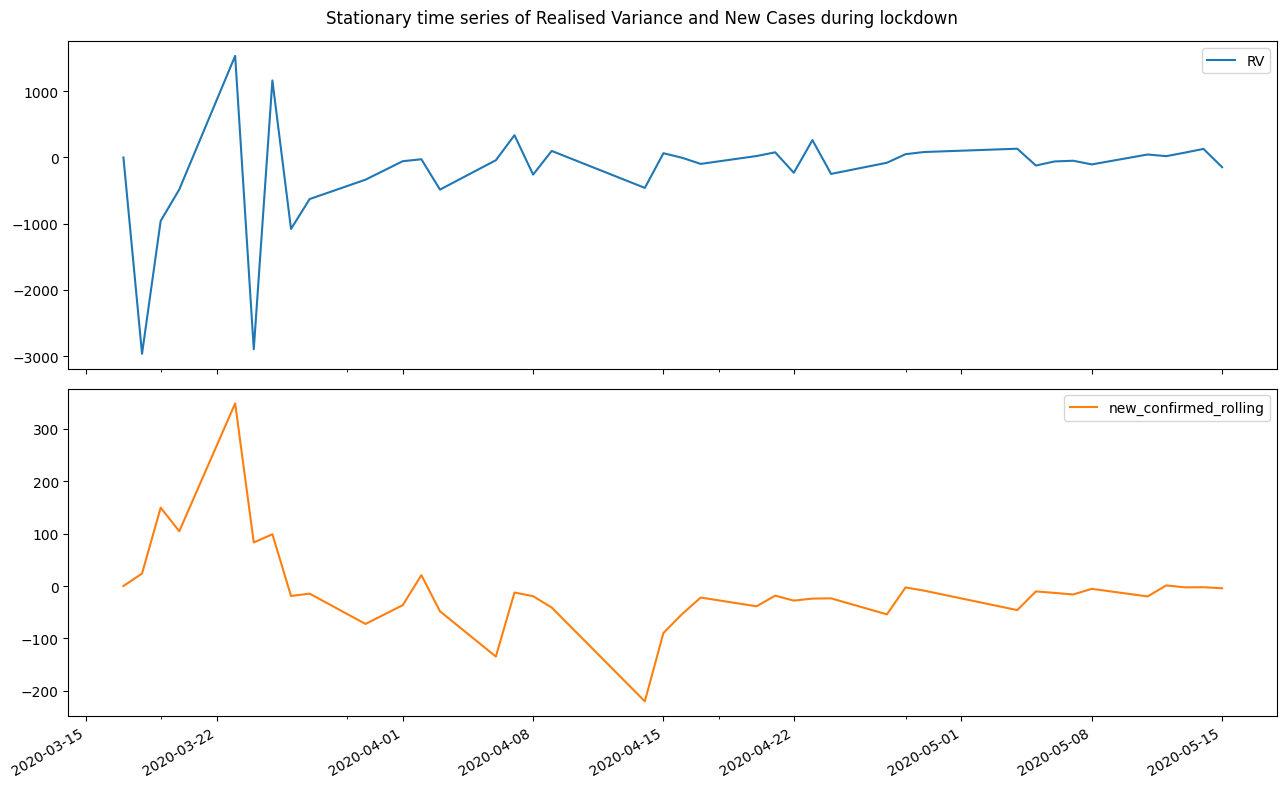


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.0,0.0


In [19]:
lockdown_che_merged = pd.merge(lockdown_che_rvs[["RV"]], dfs_covid_lockdown["CHE"][["new_confirmed_rolling"]], 
                      how="inner", left_index=True,
                      right_index=True)
granger_causality(lockdown_che_merged, granger_vars, "Realised Variance and New Cases during lockdown")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.8841
 No. Lags Chosen      = 2
 Critical value 1%     = -3.585
 Critical value 5%     = -2.928
 Critical value 10%    = -2.602
 => P-Value = 0.3396. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed_rolling" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.217
 No. Lags Chosen      = 8
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.2001. Weak evidence to reject H0.
 => Series in Non-Stationary




/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:103: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_confirmed_stat[country][0] = 0
/workspaces/capstone/Notebooks/Investigating local markets/granger

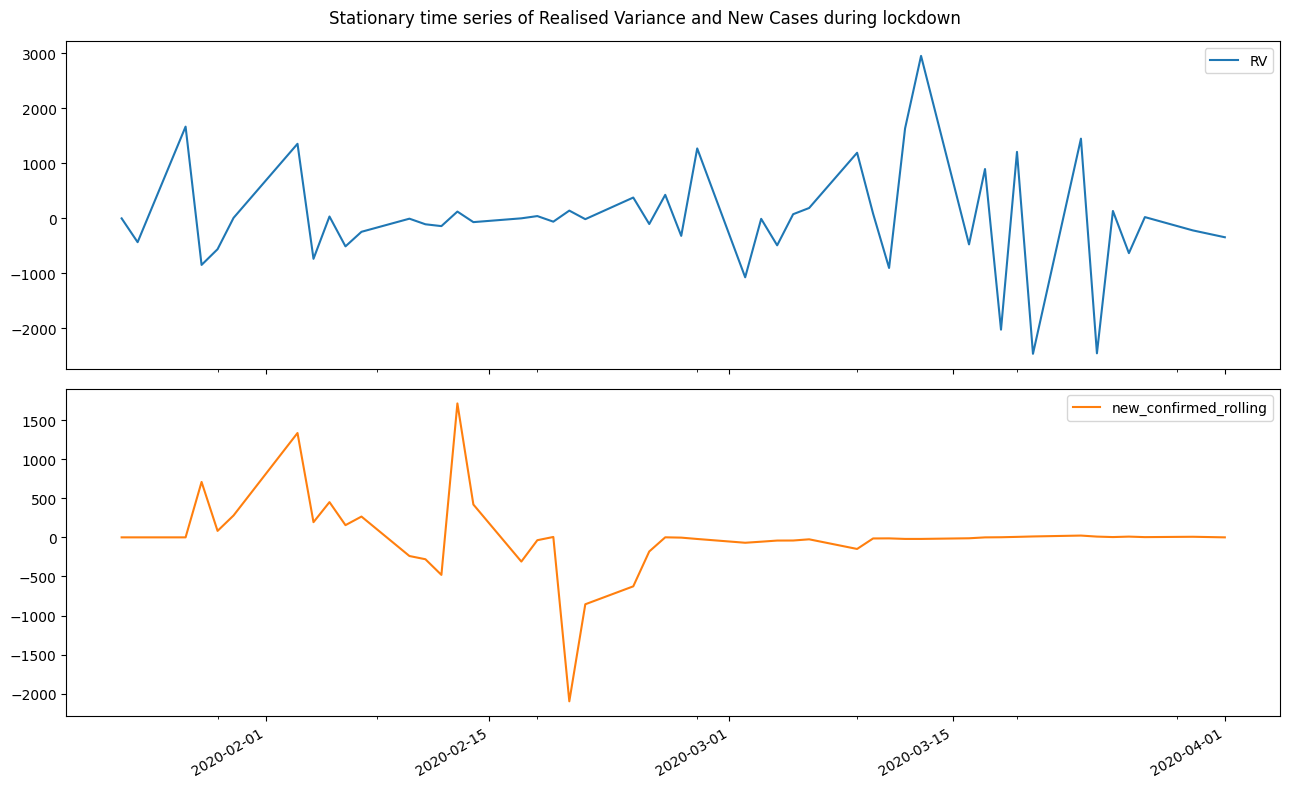


GRANGER CAUSALITY MATRIX: 



/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/workspaces/capstone/Notebooks/Investigating local markets/granger_causality_functions.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(granger_matrix.style.applymap(lambda x: "background-col

,RV_x,new_confirmed_rolling_x
RV_y,0.0,0.0
new_confirmed_rolling_y,0.616,0.0


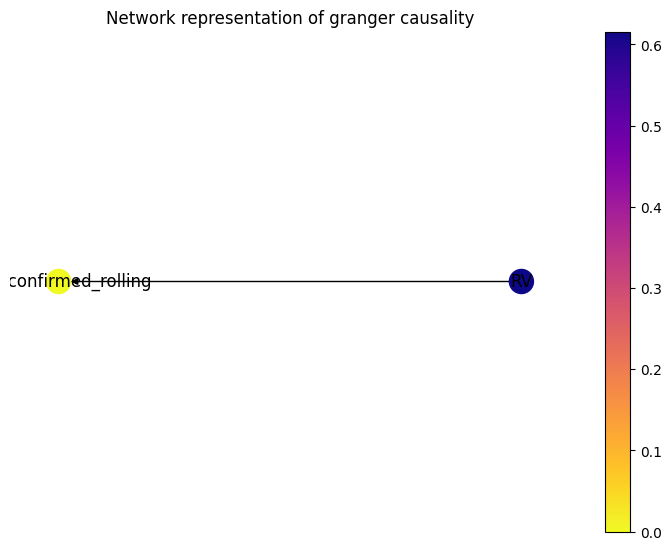

,RV_x,new_confirmed_rolling_x
RV_y,0.000,0.0
new_confirmed_rolling_y,0.616,0.0


In [20]:
lockdown_chi_merged = pd.merge(lockdown_chi_rvs[["RV"]], dfs_covid_lockdown["CHN"][["new_confirmed_rolling"]], 
                      how="inner", left_index=True,
                      right_index=True)
granger_causality(lockdown_chi_merged, granger_vars, "Realised Variance and New Cases during lockdown")